# UCM analysis with stats

---
- 2021-04-25
    - [x] UCM, CM, IS extraction
    - [x] Statistical analysis
- 2021-04-27
    - Use of Guided PCA (included F3)

In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os
import pickle
import re
import sys
from glob import glob
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.ensemble import IsolationForest
from tqdm import notebook, tqdm
from pprint import pprint

src_dir = '/home/jkang/project/Articulatory-Data-Processor'
sys.path.append(src_dir)
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA
from tools.ucm import get_weights, get_ucm_cm, get_score_lr, nullspace

# Differentiation
import numdifftools as nd
from jax import jacfwd, jacrev
import jax.numpy as jnp

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from ruamel.yaml import YAML

rand_seed = 0
flatten = itertools.chain.from_iterable
print('loaded')

loaded


In [2]:
# ----- Options
save_again = False
plot_again = False
use_mel = True
use_guided_pca = True

# ----- Directories
curr_dir = '.'
data_dir = 'data'
save_dir = os.path.join(curr_dir, 'forward_model')
param_dir = os.path.join(curr_dir, 'data_processed')
# data_file = os.path.join(curr_dir, 'data_processed', 'data_2021-04-13.csv')
data_file = os.path.join(curr_dir, 'data_processed', 'data_2021-04-27.csv')

data_files = sorted(glob(os.path.join(data_dir, '[FM]**.txt')))
pal_files = sorted(glob(os.path.join(data_dir, 'palate_*.pkl')))

# ----- Parameters
spkr_list = ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
# acous_col = ['F1', 'F2']
acous_col = ['F1', 'F2', 'F3']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
num_pca = 3
if use_guided_pca:
    pca_col = ['JAW','LIPS','vTNG','hTNG']
else:
    pca_col = ['PC1','PC2','PC3']
rate_list = ['N', 'F']
num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    "IY1": "i",
    "IH1": "ɪ",
    "EH1": "ɛ",
    "AO1": "ʌ",
    "AH1": "ɔ",
    "AA1": "ɑ",
    "AE1": "æ",
    "UH1": "ʊ",
    "UW1": "u",
}
num2vowel = {i:v for i, v in enumerate(vowel2ipa.keys())}
vowel2num = {num2vowel[i]:i for i in num2vowel.keys()}

# ----- Plots
xm = 2.5
ym = 2.5
lim = [-0.9, 0.9]

print('Save again:', save_again)
print('Plot again:', plot_again)
print('Guided PCA:', use_guided_pca)

Save again: False
Plot again: False
Guided PCA: True


## Prepare data

In [3]:
D = pd.read_csv(data_file)
print(D.shape)
D.head(3) 

(140305, 59)


,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
0,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.292038,0.089631,-0.164699,0.136676,0.353518,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.311505,0.089876,-0.163489,0.147812,0.389433,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
2,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.333751,0.089203,-0.161451,0.158579,0.414875,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue


### Filter data by PreVowelPOA

In [4]:
DN = D.loc[D.PreVowelPOA.isin(['bilabial','alveolar','velar'])].reset_index(drop=True)
print(DN.shape)
DN.head(3)

(84430, 59)


,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
0,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.292038,0.089631,-0.164699,0.136676,0.353518,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.311505,0.089876,-0.163489,0.147812,0.389433,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
2,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.333751,0.089203,-0.161451,0.158579,0.414875,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue


In [5]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
assert sorted(vowel_list_all) == sorted(vowel_list)
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print('Speaker:', spkr_list)
print('Unique words: ', len(word_list))
print('Vowels (     all):', vowel_list_all)
print('Vowels (selected):', vowel_list)  # 9 vowels selected
print('Times:', time_list)
print('Blocks:', block_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Unique words:  1056
Vowels (     all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
Times: [0.0, 0.25, 0.5, 0.75, 1.0]
Blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [6]:
# Load palate
pal_all = load_palate(pal_files, spkr_list)
print('Loaded: ', pal_all.keys())

Loaded:  dict_keys(['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04'])


In [7]:
# Load data parameters
with open(os.path.join(param_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
if use_guided_pca:
    pca_file = os.path.join(param_dir, 'gpca.pkl')
else:
    pca_file = os.path.join(param_dir, 'pca.pkl')
with open(pca_file, 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(param_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(param_dir, 'grand_means.csv'))
print('Loaded')

Loaded


## Import tools

In [8]:
def _load_model_params(save_dir, which_spkr):
    with open(os.path.join(save_dir, which_spkr, 'model_linear.pckl'), 'rb') as pckl:
        LR = pickle.load(pckl)
        weights = LR['weights']
        lr_model = lambda x: x.dot(weights)

    with open(os.path.join(save_dir, which_spkr, 'model_ann.pckl'), 'rb') as pckl:
        ANN = pickle.load(pckl)
        ann_model = ANN['model'].predict
        
    with open(os.path.join(save_dir, which_spkr, 'ucm_cm.pckl'), 'rb') as pckl:
        UCM = pickle.load(pckl)

    # Prepare palate
    pal = pal_all[which_spkr]

    # Initiate
    scaler = Scaler(which_spkr, Z)
    if use_guided_pca:
        pca = PC[which_spkr]['gpca']
    else:
        pca = PC[which_spkr]['pca']
    return LR, ANN, lr_model, ann_model, pal, scaler, pca, UCM

LR, ANN, _, _, _, _, _, _ = _load_model_params(save_dir, 'F01')
LR, ANN

({'weights': array([[ 0.42781094, -0.42209273, -0.9019086 ],
         [ 0.19249593,  1.15784195,  0.48087101],
         [ 0.50741325, -0.69571891,  0.33150152],
         [-0.00315558, -0.7406599 , -0.45244725]]),
  'train_score': 0.6121043603592867,
  'test_score': 0.5845776352424786,
  'train_rmse': 0.40029404562724463,
  'test_rmse': 0.41166632203162523,
  'model_as_string': 'lambda x: x.dot(weights)'},
 {'model': MLPRegressor(early_stopping=True, hidden_layer_sizes=[256, 256, 256],
               learning_rate='adaptive', max_iter=1000, n_iter_no_change=50,
               random_state=0),
  'train_score': 0.8081286711348827,
  'test_score': 0.7549172102316658,
  'train_rmse': 0.25478210847083843,
  'test_rmse': 0.28440225013496295})

In [9]:
def _prep_data_for_ucm(D, model_dir, model_type, which_spkr, which_vowel, which_rate, which_time, 
                       lim=[-0.5,0.5], nsample=5, use_median=False):
    # Prepare params
    LR, ANN, lr_model, ann_model, pal, scaler, pca, UCM = _load_model_params(model_dir, which_spkr)

    # Prepare original data
    if which_rate == 'NF':
        which_rate = ['N', 'F']
    else:
        which_rate = [which_rate]
    cond = ((D.Speaker==which_spkr)&
            (D.Vowel==which_vowel)&
            (D.TimeAt==which_time)&
            (D.Rate.isin(which_rate)))
    formants = D.loc[cond, acous_col].values
    artics = D.loc[cond, artic_col].values
    artics = scaler.transform(artics, 'artic')
    artics = pca.transform(artics).squeeze()
    
    median = (VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel.isin(vowel_list))&(VT.TimeAt==which_time)]
              .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
              .values) # acous median
    
    # Get vowel-median artic data 
    #vdata = VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel==which_vowel), artic_col].values
    #vdata = D.loc[cond, artic_col].median(axis=0).values[np.newaxis,:]
    if use_median:
        vdata = D.loc[cond, artic_col].median(axis=0).values[np.newaxis,:]
    else:
        vdata = D.loc[cond, artic_col].mean(axis=0).values[np.newaxis,:]
    vdata = scaler.transform(vdata, 'artic')
    vdata = pca.transform(vdata).squeeze()
    init_pcs = vdata

    # Prepare models
    if model_type=='LR':
        ucm_vec = UCM[which_vowel][which_time]['LR']['ucm_vec']
        cm_vec = UCM[which_vowel][which_time]['LR']['cm_vec']
        #ucm_vec = LR[which_model]['ucm_vec']
        #cm_vec = LR[which_model]['cm_vec']
        #model = lambda X: X.dot(LR[which_model]['weights'])
        model = lambda X: X.dot(LR['weights'])
    elif model_type=='ANN':
        ucm_vec = UCM[which_vowel][which_time]['ANN']['ucm_vec']
        cm_vec = UCM[which_vowel][which_time]['ANN']['cm_vec']
        #ucm_vec = ANN[which_model]['ucm_vec']
        #cm_vec = ANN[which_model]['cm_vec']
        #model = ANN[which_model]['model'].predict
        model = ANN['model'].predict

    # Make 1-d UCM line (THIS IS INCORRECT)
    d = [(init_pcs+ucm_vec.T*i).tolist()[0] for i in np.linspace(lim[0], lim[1], nsample)]
    d = np.array(d)
    return model, init_pcs, ucm_vec, cm_vec, d, median, pal, scaler, pca, artics, formants

## Compute UCM, CM, IS score by speaker, rate, vowel, time, pre POA

In [10]:
DN.columns

Index(['Token', 'FileID', 'Speaker', 'Block', 'Rate', 'Sent', 'Rep', 'Word',
       'PreVowel', 'Vowel', 'PostVowel', 'Duration', 'TimeAt', 'TimeSec', 'F1',
       'F2', 'F3', 'TRx', 'TRz', 'TBx', 'TBz', 'TTx', 'TTz', 'JAWx', 'JAWz',
       'ULx', 'ULz', 'LLx', 'LLz', 'F1_mel', 'F2_mel', 'F3_mel', 'AcousVar',
       'ArticVar', 'RescaleFactorAcous', 'RescaleFactorArtic', 'F1_grandmean',
       'F2_grandmean', 'F3_grandmean', 'F1_norm', 'F2_norm', 'F3_norm',
       'TRx_norm', 'TRz_norm', 'TBx_norm', 'TBz_norm', 'TTx_norm', 'TTz_norm',
       'JAWx_norm', 'JAWz_norm', 'ULx_norm', 'ULz_norm', 'LLx_norm',
       'LLz_norm', 'PreVowelPOA', 'PostVowelPOA', 'Pronunciation', 'Tag',
       'PlaceOfArticulation'],
      dtype='object')

In [11]:
DN.PreVowelPOA.unique()

array(['alveolar', 'bilabial', 'velar'], dtype=object)

In [12]:
which_init_pcs = 'N' # N, F, NF

which_time = 0.5
# which_model = 'all'
model_type = 'ANN' # ANN, LR
suffix = 'NF_ucm_cm_proj'
lim = [-10, 10]  # synthesis range
pca_lim = [-2,2]
nsample = 5
pca_col = ['JAW','LIPS','vTNG','hTNG']
npc = len(pca_col)
rate_colors = sns.color_palette('tab10', len(rate_list))

n_tot = len(pca_col)
n_ucm = n_tot - len(acous_col)
n_cm = n_tot - n_ucm
print('n_tot:', n_tot)
print('n_ucm:', n_ucm)
print('n_cm:', n_cm)

dfs = []
for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    
    for which_vowel in vowel_list:
        # For N rate
        model, init_pcs, ucm_vec, cm_vec, ucm_space, median, pal, scaler, pca, _, _ = _prep_data_for_ucm(
            DN, save_dir, model_type,  # dir, model
            which_spkr, which_vowel, 'N', which_time,  # conditions
            lim=lim, nsample=nsample)
        
        for which_rate in ['F', 'N']:
            
            for which_poa in DN.PreVowelPOA.unique():
                #['alveolar', 'bilabial', 'velar']
                
                # For N rate
                _, _, _, _, _, _, _, _, _, artics, formants = _prep_data_for_ucm(
                    DN.loc[DN.PreVowelPOA==which_poa], save_dir, model_type,  # dir, model
                    which_spkr, which_vowel, which_rate, which_time,  # conditions
                    lim=lim, nsample=nsample)

                # Make sure to center artics by substracting init_pcs
                if len(artics.shape) == 1:
                    artics = artics.reshape((1, -1))
                    
                artics_raw = artics
                artics_centered = artics - init_pcs
                #artics_centered = artics_raw - artics_raw.mean(axis=0)

                artics_var = np.diag(artics_centered.T.dot(artics_centered)) # per PC1, PC2, PC3, PC4
                artics_var_tot = artics_var.sum()

                NF = pd.DataFrame({col: artics_raw[:, i] for i, col in enumerate(pca_col)})
                NF['Speaker'] = which_spkr
                NF['Vowel'] = which_vowel
                NF['Rate'] = [which_rate]*(artics.shape[0]) # this changed plotting zorder!!
                NF['POA'] = which_poa

                # Project data onto UCM and CM
                nsamples = artics_centered.shape[0]
                ucm_vec = ucm_vec / np.linalg.norm(ucm_vec)
                ucm_proj_centered = artics_centered.dot(ucm_vec.dot(ucm_vec.T)) # Nx4
                cm_proj_centered = artics_centered.dot(cm_vec.dot(cm_vec.T))    # Nx4

                ucm_var = (ucm_proj_centered**2).sum(axis=1)
                cm_var = (cm_proj_centered**2).sum(axis=1)
                ucm_var_sqrt = np.sqrt(ucm_var/n_ucm) # sqrt
                cm_var_sqrt = np.sqrt(cm_var/n_cm)   # sqrt

                NF[[f'{col}_ucm' for col in pca_col]] = pd.DataFrame(ucm_proj_centered)
                NF[[f'{col}_cm' for col in pca_col]] = pd.DataFrame(cm_proj_centered)
                NF['sqrt_norm_UCM'] = ucm_var_sqrt
                NF['sqrt_norm_CM'] = cm_var_sqrt
                NF['ucm_cm_score'] = ucm_var_sqrt / cm_var_sqrt
                #NF['ucm_minus_cm_over_var'] = (ucm_var_sqrt - cm_var_sqrt) / np.sqrt(artics_var_tot)
                NF['ucm_minus_cm_over_var'] = (ucm_var_sqrt - cm_var_sqrt) / (ucm_var_sqrt + cm_var_sqrt)
                NF['ucm_ratio_quotient'] = 2 * (ucm_var_sqrt**2) / (ucm_var_sqrt**2 + cm_var_sqrt**2) - 1 # See Mohler et al 2020
                NF['total_var'] = (ucm_var_sqrt**2 + cm_var_sqrt**2)
                NF[[f'{col}_var' for col in pca_col]] = pd.DataFrame(artics_var.reshape(1,-1))

                dfs += [NF]
            
NF = pd.concat(dfs)

  0%|          | 0/8 [00:00<?, ?it/s]

n_tot: 4
n_ucm: 1
n_cm: 3


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


In [13]:
def _wide_to_long(df, j_columns, prefix, sep='-', i_columns=['Speaker', 'Rate', 'Vowel'], 
                  outcolumn='Type', suffix='\\w+'):
    # j_columns: a list of column names; a column of interest as dependent variable;  eg. artic_col, acous_col
    # i_columns: usually factors or independent variables; eg. Speaker, Vowel, ...
    # stubnames: prefix of the column names
    df = df.copy()
    df['id'] = df.index
    df = df[['id']+i_columns+j_columns]
    for col in j_columns:
        df.rename(columns={col: prefix+sep+col}, inplace=True)
    df = pd.wide_to_long(df, stubnames=prefix, sep=sep, suffix=suffix,
                         i=['id']+i_columns,
                         j=outcolumn).reset_index()
    return df

DF = _wide_to_long(NF, j_columns=['sqrt_norm_UCM','sqrt_norm_CM'], 
                   prefix='sqrt_norm', sep='_', 
                   i_columns=['Speaker', 'Rate','POA', 'Vowel','ucm_cm_score', 'ucm_ratio_quotient', 
                              'total_var','ucm_minus_cm_over_var'])
DF

,id,Speaker,Rate,POA,Vowel,ucm_cm_score,ucm_ratio_quotient,total_var,ucm_minus_cm_over_var,Type,sqrt_norm
0,0,F01,F,alveolar,IY1,0.385146,-0.741648,0.037991,-0.443891,UCM,0.070053
1,0,F01,F,alveolar,IY1,0.385146,-0.741648,0.037991,-0.443891,CM,0.181888
2,1,F01,F,alveolar,IY1,1.005457,0.005442,0.060264,0.002721,UCM,0.174057
3,1,F01,F,alveolar,IY1,1.005457,0.005442,0.060264,0.002721,CM,0.173113
4,2,F01,F,alveolar,IY1,0.791989,-0.229070,0.018672,-0.116078,UCM,0.084838
...,...,...,...,...,...,...,...,...,...,...,...
33767,37,M04,N,velar,UW1,3.905545,0.876948,0.030335,0.592298,CM,0.043202
33768,38,M04,N,velar,UW1,0.620432,-0.444111,0.082159,-0.234239,UCM,0.151115
33769,38,M04,N,velar,UW1,0.620432,-0.444111,0.082159,-0.234239,CM,0.243565
33770,39,M04,N,velar,UW1,1.731614,0.499811,0.143669,0.267832,UCM,0.328235


## Visualize UCM, CM, IS

In [15]:
ylim_sqrt = [-0.05,1.4]

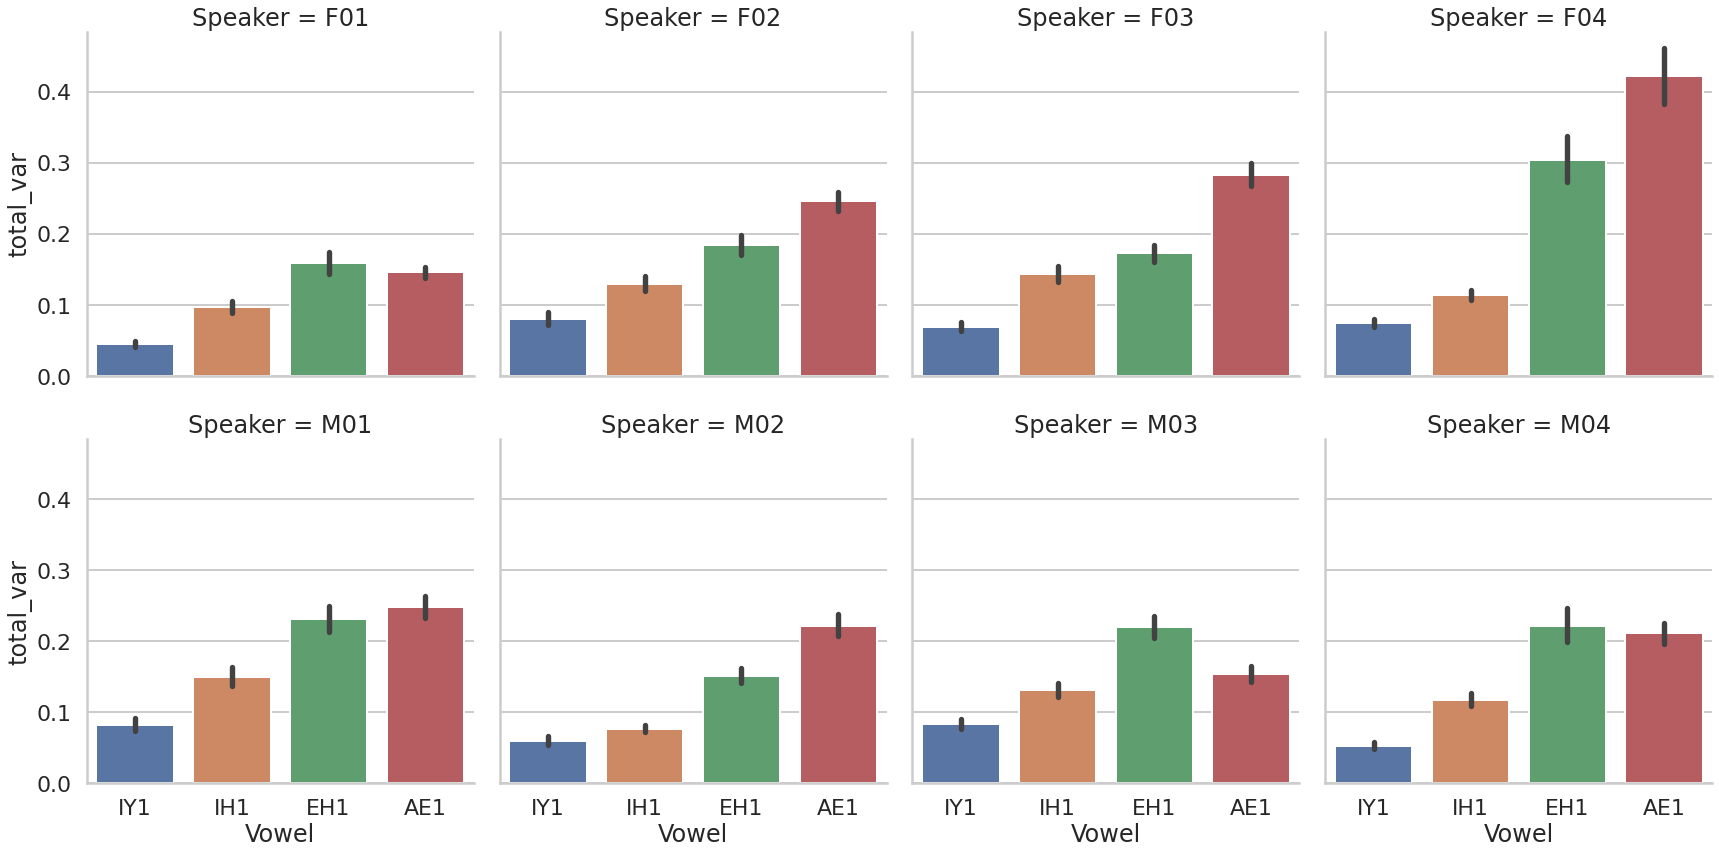

In [21]:
sns.set_theme(style='whitegrid')
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='total_var', 
                    data=DF.loc[(DF.Vowel.isin(custom_vowels))],
                    kind='bar', col_wrap=4, height=6)#.set(ylim=[0,300])

### Original UCM/CM score

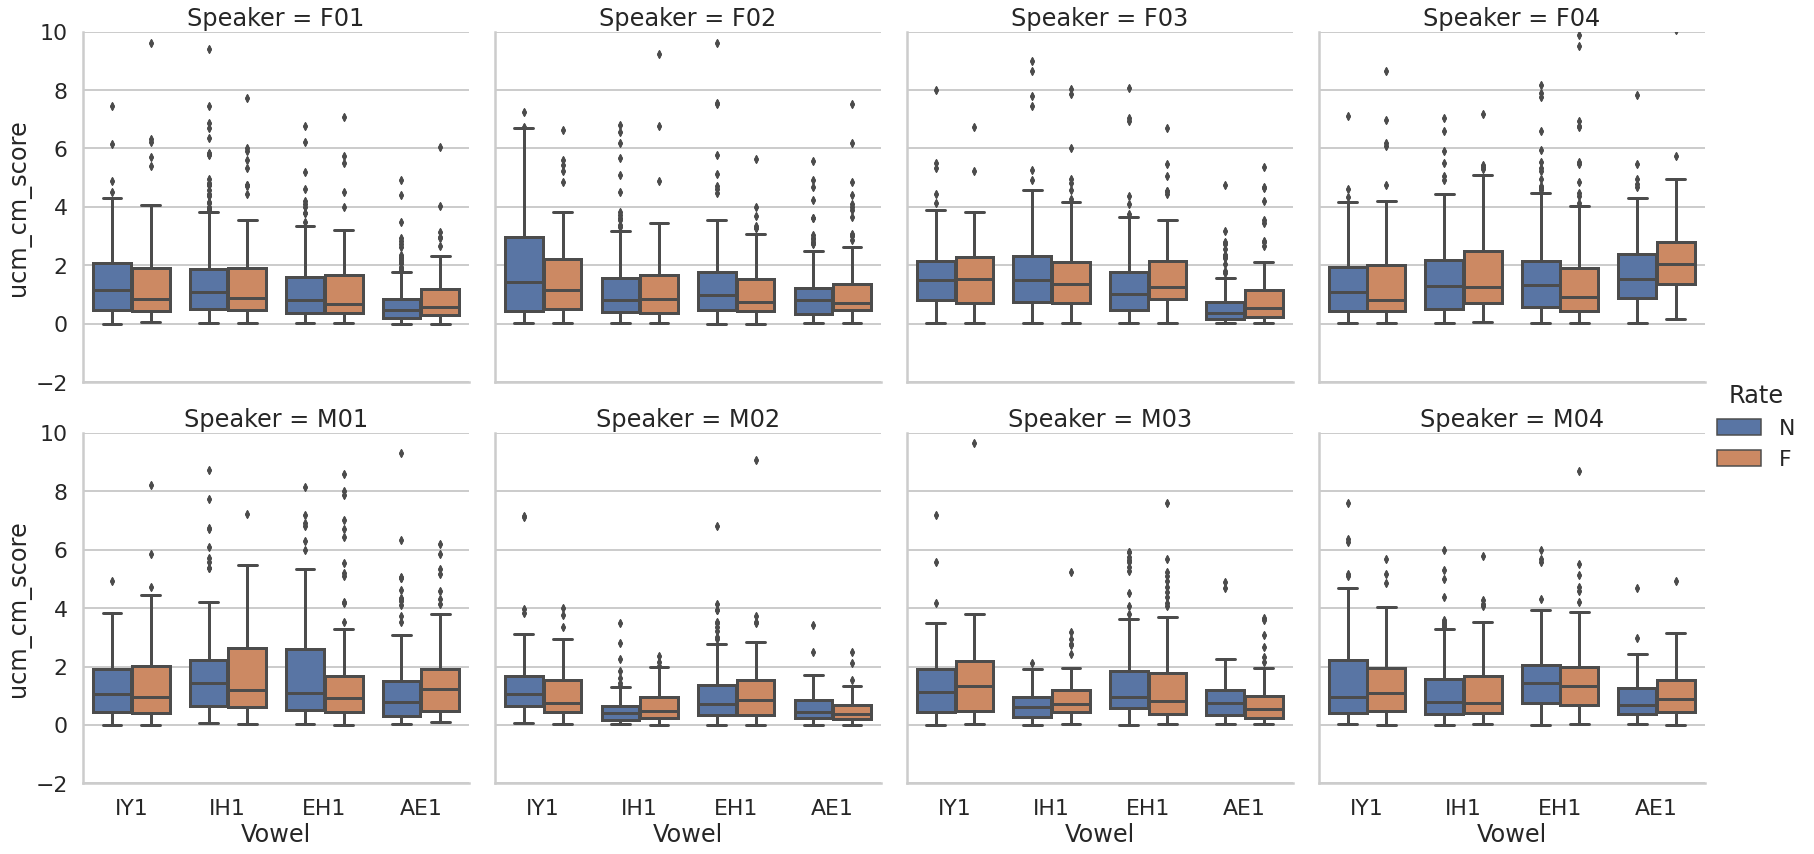

In [22]:
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='ucm_cm_score', 
                    hue='Rate', hue_order=rate_list,
                    data=DF.loc[(DF.Vowel.isin(custom_vowels))],
                    kind='box', col_wrap=4, height=6).set(ylim=(-2, 10))

### Index of Synergy

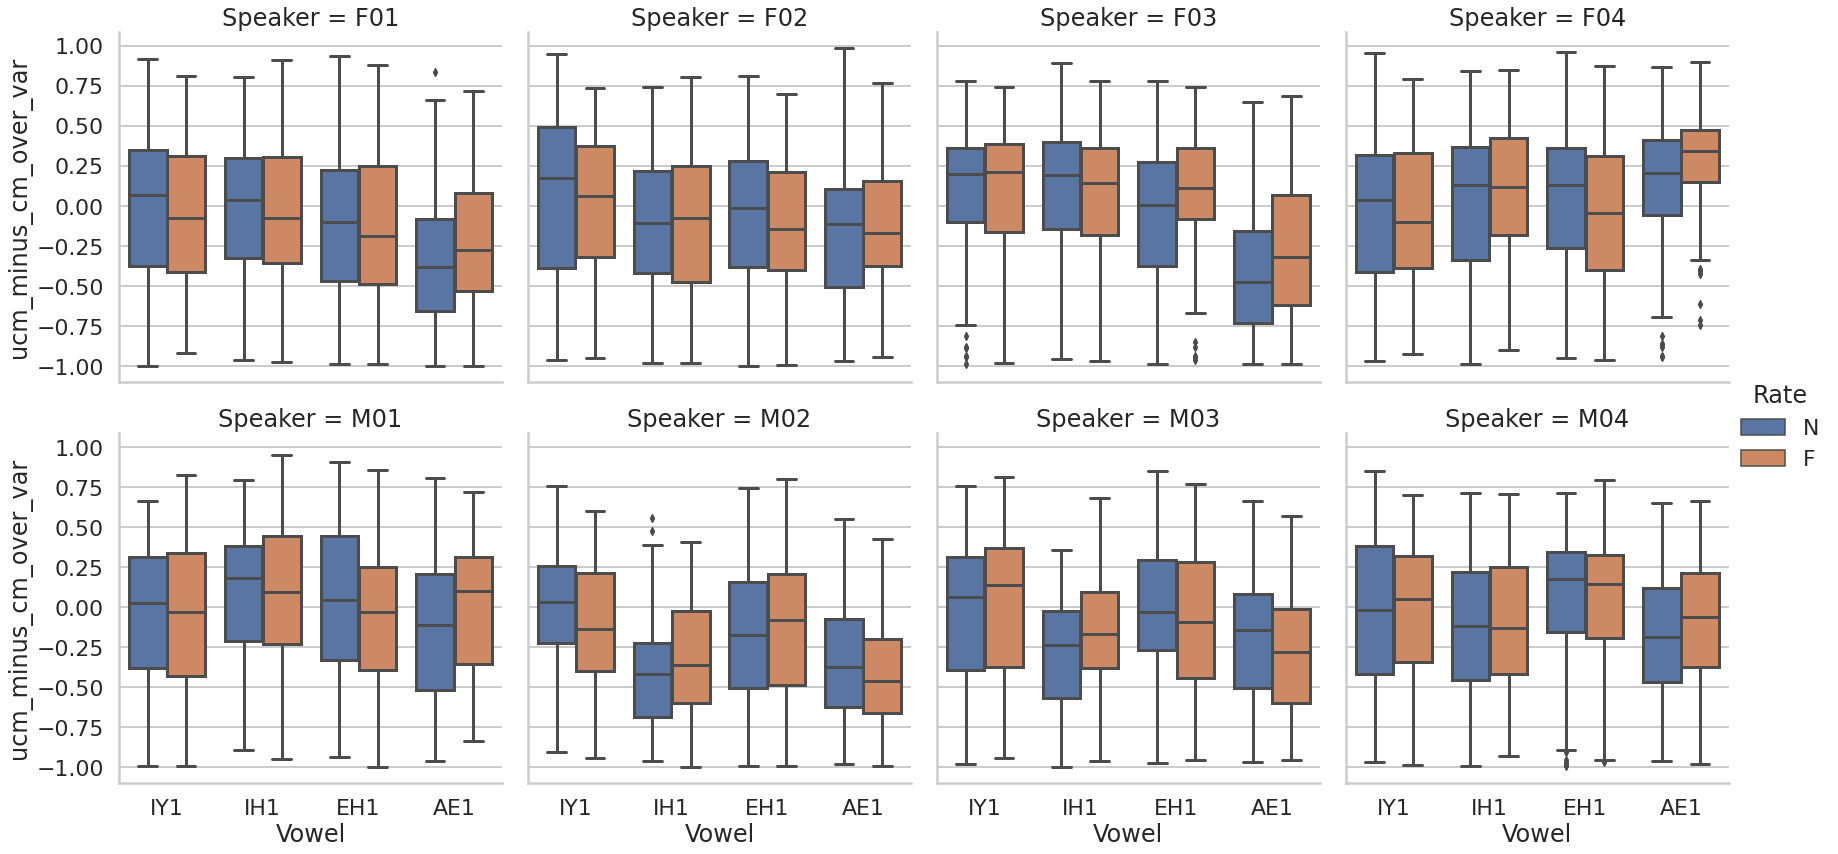

In [23]:
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='ucm_minus_cm_over_var', 
                    hue='Rate', hue_order=rate_list,
                    data=DF.loc[(DF.Vowel.isin(custom_vowels))],
                    kind='box', col_wrap=4, height=6)

### UCM ratio quotient (Mohler et al 2020)

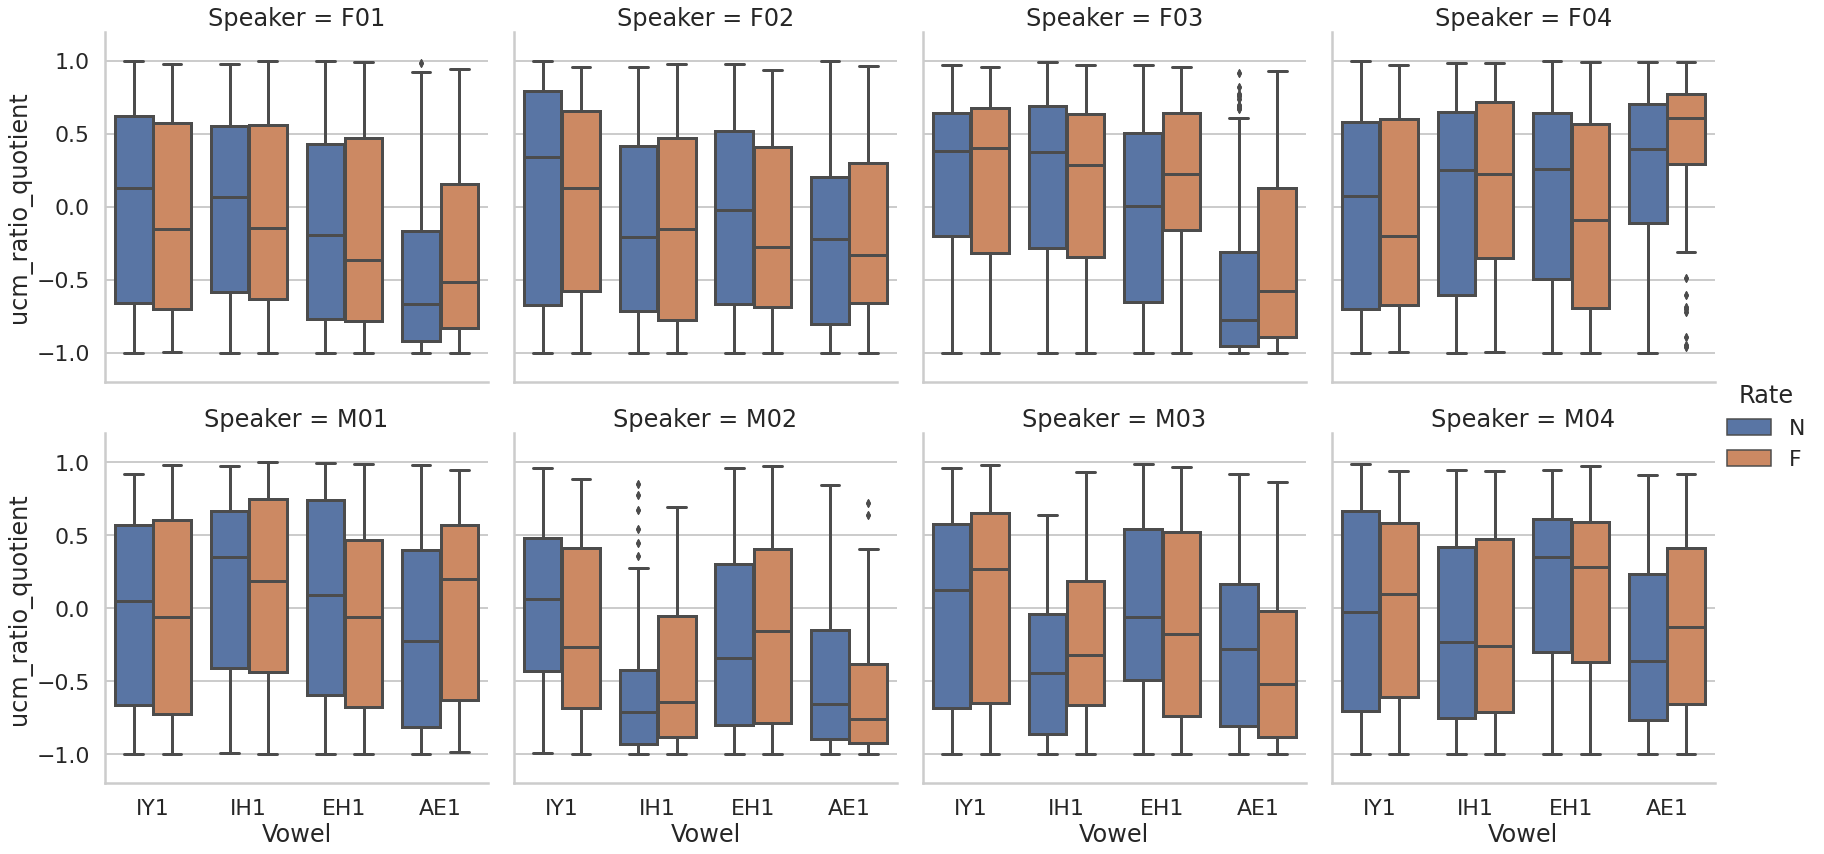

In [24]:
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='ucm_ratio_quotient', 
                    hue='Rate', hue_order=rate_list,
                    data=DF.loc[(DF.Vowel.isin(custom_vowels))],
                    kind='box', col_wrap=4, height=6).set(ylim=(-1.2,1.2))

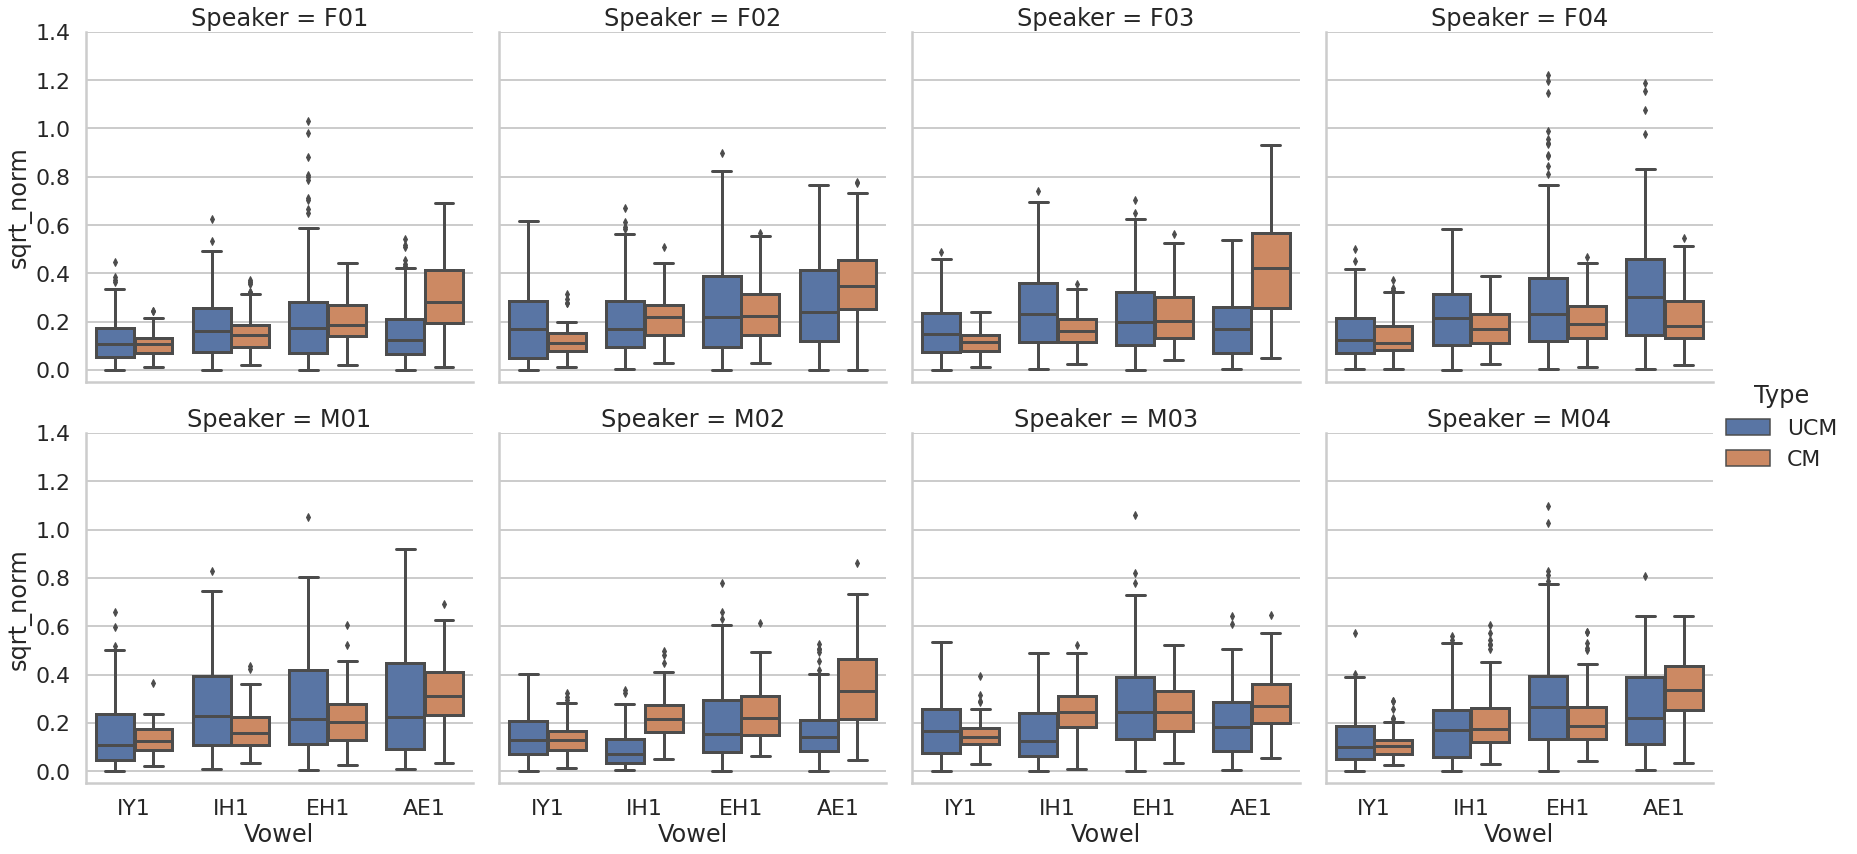

In [25]:
# Normal rate
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='sqrt_norm', 
                    hue='Type', 
                    data=DF.loc[(DF.Rate=='N')&(DF.Vowel.isin(custom_vowels))],
                    order = custom_vowels,
                    kind='box', col_wrap=4, height=6)
    g = (g.set(ylim=ylim_sqrt))

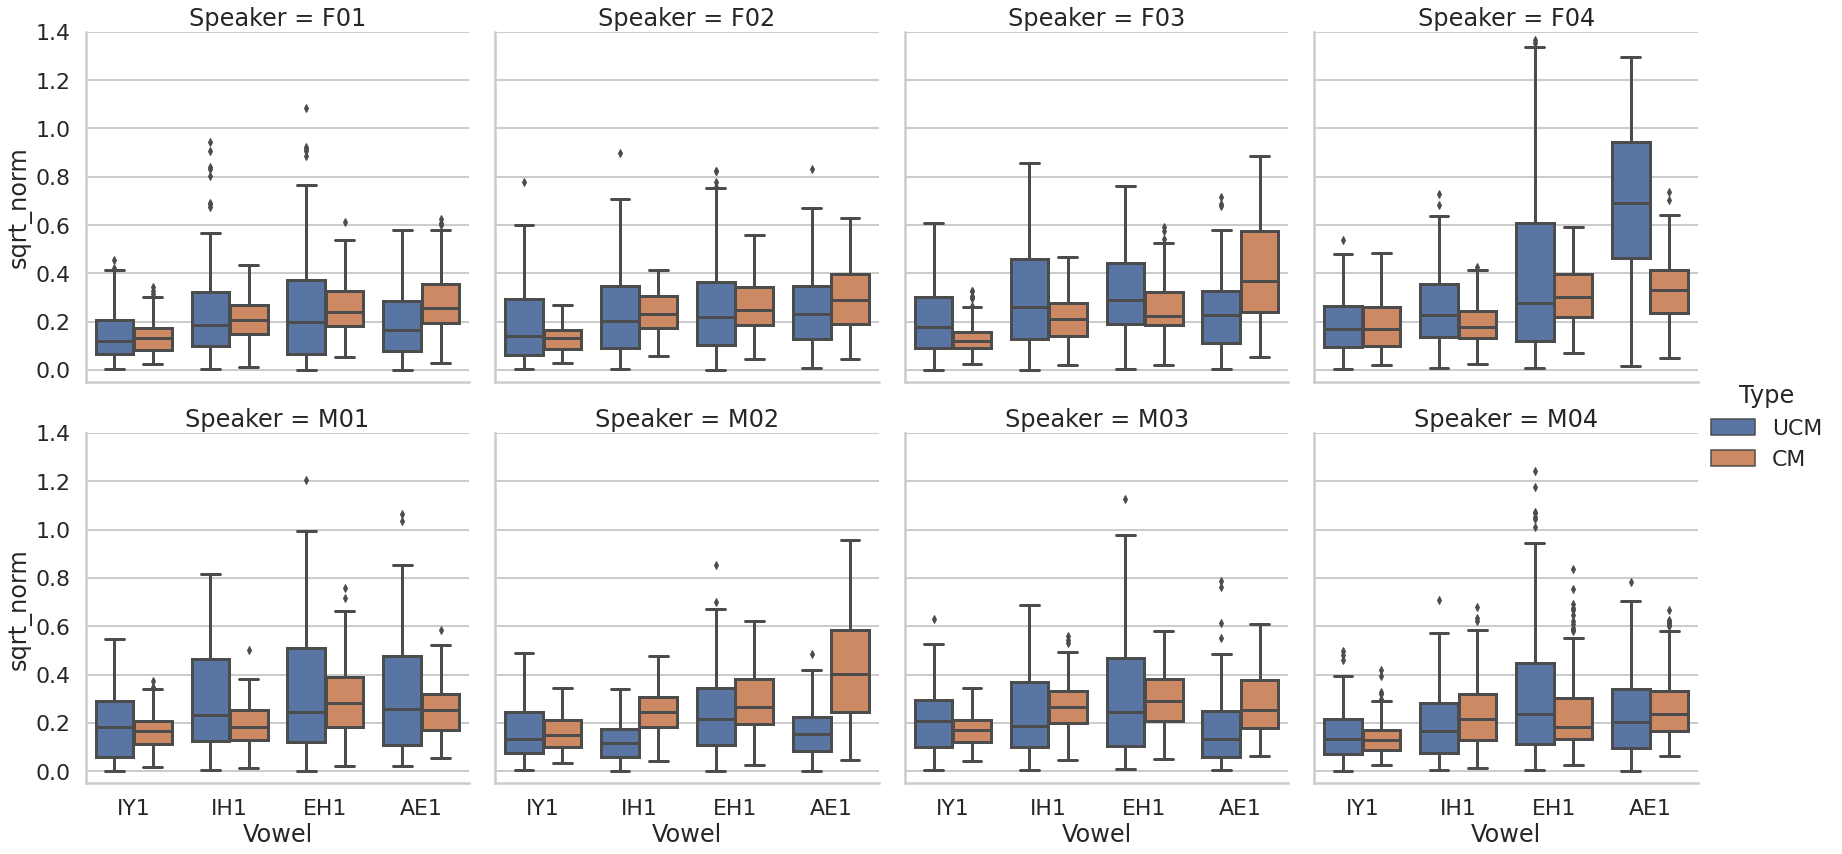

In [26]:
# Fast rate
with sns.plotting_context('poster'):
    g = sns.catplot(col='Speaker', x='Vowel', y='sqrt_norm', hue='Type',
                    data=DF.loc[(DF.Rate=='F')&(DF.Vowel.isin(custom_vowels))],
                    order = custom_vowels,
                    kind='box', col_wrap=4, height=6)
    g = (g.set(ylim=ylim_sqrt))

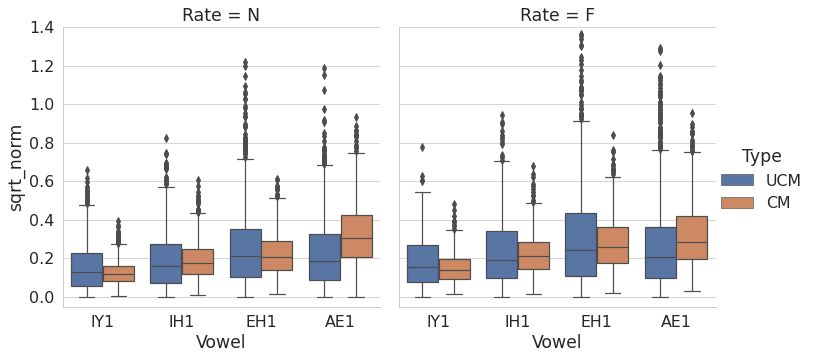

In [27]:
with sns.plotting_context('paper', font_scale=1.8):
    g = sns.catplot(col='Rate', x='Vowel', y='sqrt_norm', hue='Type',
                    data=DF.loc[(DF.Vowel.isin(custom_vowels))],
                    order = custom_vowels,
                    col_order=['N','F'],
                    kind='box')
    g = (g.set(ylim=ylim_sqrt))

---

## Statistics

In [14]:
%load_ext rpy2.ipython

In [29]:
%%R
# Stat
library(car)
library(stats)
library(lme4)
library(emmeans)

# Plotting
library(ggplot2)
library(ggeffects)
library(ggpubr)
library(sjPlot)
library(effects)
library(latex2exp)

R[write to console]: lattice theme set by effectsTheme()
See ?effectsTheme for details.



In [16]:
%%capture
%%R
par(family  = "Arial")
install.packages("showtext")
library(showtext)
showtext_auto()

### Prepare data

In [17]:
# d = NF.copy()
# d = d.rename(columns={'POA':'PreVowelPOA'})
# print(d.shape)
# d.head()
# Choose vowel mid-point
d = NF.loc[(NF.Vowel.isin(custom_vowels))].reset_index(drop=True)
d = d.rename(columns={'POA':'Context'})
print('shape', d.shape)
d.head(3)

shape (8344, 26)


,JAW,LIPS,vTNG,hTNG,Speaker,Vowel,Rate,Context,JAW_ucm,LIPS_ucm,...,sqrt_norm_UCM,sqrt_norm_CM,ucm_cm_score,ucm_minus_cm_over_var,ucm_ratio_quotient,total_var,JAW_var,LIPS_var,vTNG_var,hTNG_var
0,-0.478191,-0.371068,-1.069610,-0.784886,F01,IY1,F,alveolar,-0.015279,-0.006043,...,0.070053,0.181888,0.385146,-0.443891,-0.741648,0.037991,0.837935,2.67643,0.948457,1.704796
1,-0.553866,-0.359964,-0.993720,-0.870101,F01,IY1,F,alveolar,-0.037964,-0.015014,...,0.174057,0.173113,1.005457,0.002721,0.005442,0.060264,NaN,NaN,NaN,NaN
2,-0.500024,-0.164608,-0.990511,-0.807281,F01,IY1,F,alveolar,-0.018504,-0.007318,...,0.084838,0.107120,0.791989,-0.116078,-0.229070,0.018672,NaN,NaN,NaN,NaN


## (1) LME model when DV: UCM

In [18]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$Speaker = as.factor(d$Speaker)
d$Context = as.factor(d$Context)

# d$Rate <- ordered(d$Rate, levels = c("N","F"))
d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1"))
d$Context = ordered(d$Context, levels=c("bilabial","alveolar","velar"))

In [19]:
%%R
m.UCM = lmer(sqrt_norm_UCM ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.UCM)

Linear mixed model fit by REML ['lmerMod']
Formula: sqrt_norm_UCM ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: -4165.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3565 -0.6995 -0.1865  0.5128  5.7536 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.002051 0.04528 
 Residual             0.034728 0.18635 
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              0.2624800  0.0167373  15.682
RateN                   -0.0469181  0.0063046  -7.442
Context.L                0.0352879  0.0097753   3.610
Context.Q                0.0161453  0.0068634   2.352
Vowel.L                  0.0723606  0.0114056   6.344
Vowel.Q                 -0.0369809  0.0097566  -3.790
Vowel.C                 -0.0464702  0.0077599  -5.989
RateN:Context.L         -0.0167465  0.0126683  -1.322
RateN:Context.Q          0.0013001  0.0088302   0.147
RateN:

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [20]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.UCM, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: sqrt_norm_UCM
                      Chisq Df Pr(>Chisq)    
(Intercept)        245.9347  1  < 2.2e-16 ***
Rate                55.3822  1  9.923e-14 ***
Context             13.2216  2  0.0013458 ** 
Vowel              111.8857  3  < 2.2e-16 ***
Rate:Context         2.8652  2  0.2386839    
Rate:Vowel           3.0777  3  0.3797928    
Context:Vowel       26.0730  6  0.0002158 ***
Rate:Context:Vowel   6.9133  6  0.3289387    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.UCM = emmeans(m.UCM, ~ Rate|Vowel, adjust = "tukey")
pairs(em.UCM)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0340 0.01965 Inf 1.732   0.0833 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0405 0.00933 Inf 4.339   <.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0605 0.00923 Inf 6.552   <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0527 0.00880 Inf 5.987   <.0001 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [22]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.UCM_1 = emmeans(m.UCM, ~ Rate|Context, adjust = "tukey")
pairs(em.UCM_1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0345 0.00729 Inf 4.740   <.0001 

Context = alveolar:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0480 0.00606 Inf 7.918   <.0001 

Context = velar:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0582 0.01637 Inf 3.558   0.0004 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [23]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.UCM_2 = emmeans(m.UCM, ~ Context|Vowel, adjust = "tukey")
pairs(em.UCM_2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar -0.000344 0.01009 Inf -0.034  0.9994 
 bilabial - velar    -0.072790 0.02890 Inf -2.519  0.0316 
 alveolar - velar    -0.072447 0.02832 Inf -2.558  0.0283 

Vowel = IH1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar  0.002805 0.01039 Inf  0.270  0.9606 
 bilabial - velar     0.005601 0.01262 Inf  0.444  0.8971 
 alveolar - velar     0.002797 0.01116 Inf  0.251  0.9660 

Vowel = EH1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar  0.015233 0.00820 Inf  1.858  0.1511 
 bilabial - velar    -0.069540 0.01277 Inf -5.446  <.0001 
 alveolar - velar    -0.084773 0.01237 Inf -6.853  <.0001 

Vowel = AE1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar -0.011540 0.00907 Inf -1.272  0.4108 
 bilabial - velar    -0.015523 0.01126 Inf -1.379  0.3519 
 alveolar - velar    -0.003983 0.01178 Inf -0.338  0.9389 



In [24]:
%%R
em.UCM.poa = emmeans(m.UCM, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.UCM.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00873 0.0164 Inf 0.531   0.5951 

Context = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.03196 0.0117 Inf 2.729   0.0063 

Context = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.06142 0.0554 Inf 1.109   0.2675 

Context = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.05299 0.0169 Inf 3.139   0.0017 

Context = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.04179 0.0121 Inf 3.454   0.0006 

Context = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.02670 0.0188 Inf 1.423   0.1548 

Context = bilabial, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.02923 0.0124 Inf 2.352   0.0187 

Context = alveolar, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.06292 0.0107 Inf 5.884   <.0001 

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



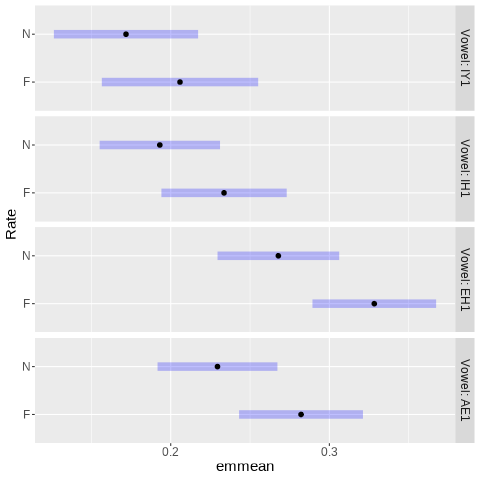

In [25]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.UCM, by = "Vowel", intervals = TRUE, type = "response")

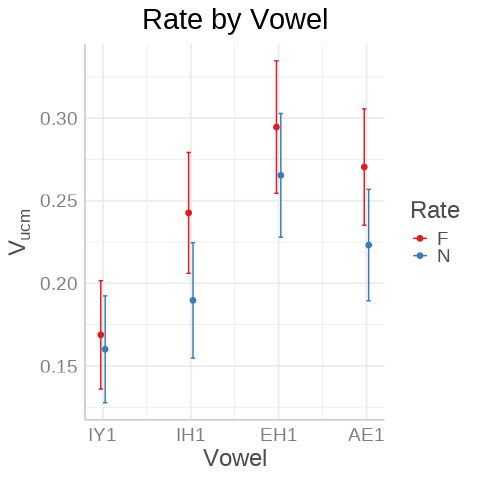

In [38]:
%%R
plot_model(m.UCM, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab(TeX('V_{ucm}'))

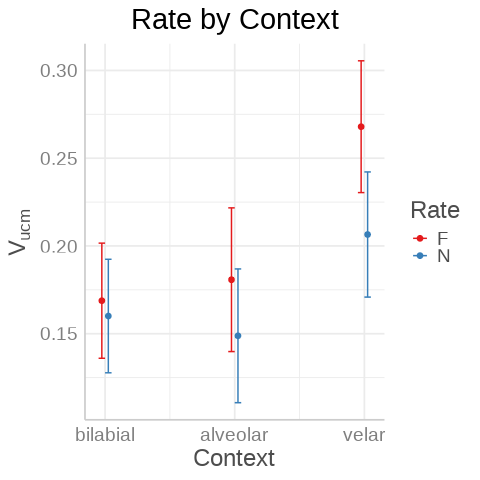

In [34]:
%%R
plot_model(m.UCM, type = "pred", terms = c("Context", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab(TeX('V_{ucm}'))

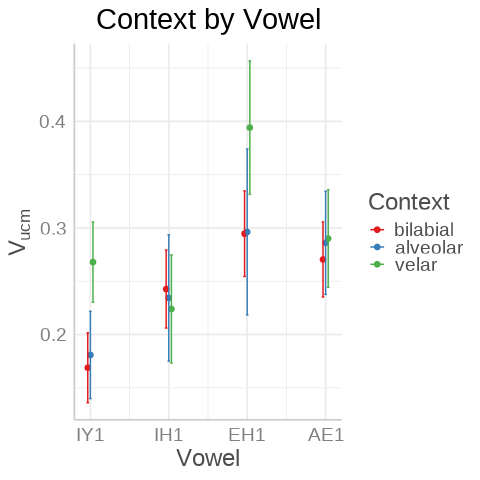

In [35]:
%%R
plot_model(m.UCM, type='pred', terms=c("Vowel","Context"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Context by Vowel') +
    ylab(TeX('V_{ucm}'))

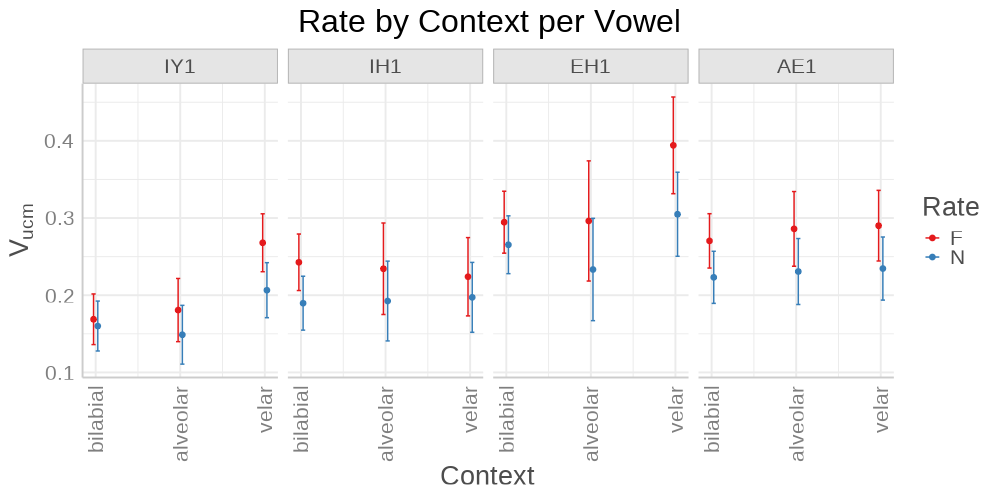

In [36]:
%%R -w 1000 -h 500
plot_model(m.UCM, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab(TeX('V_{ucm}'))
    #+ ylim(-0.6, 0.6)

## (2) LME model when DV: CM

In [42]:
%%R
m.CM = lmer(sqrt_norm_CM ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.CM)

Linear mixed model fit by REML ['lmerMod']
Formula: sqrt_norm_CM ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: -11666.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9329 -0.6459 -0.1097  0.5543  5.0404 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Speaker  (Intercept) 0.0003183 0.01784 
 Residual             0.0141089 0.11878 
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              0.251395   0.007033  35.743
RateN                   -0.030858   0.004018  -7.679
Context.L                0.021909   0.006231   3.516
Context.Q               -0.009372   0.004375  -2.142
Vowel.L                  0.117375   0.007270  16.146
Vowel.Q                 -0.003376   0.006219  -0.543
Vowel.C                 -0.009316   0.004946  -1.883
RateN:Context.L         -0.014933   0.008075  -1.849
RateN:Context.Q          0.013640   0.005628   2.424
RateN:Vowel.L

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [43]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.CM, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: sqrt_norm_CM
                      Chisq Df Pr(>Chisq)    
(Intercept)        1277.541  1  < 2.2e-16 ***
Rate                 58.970  1  1.601e-14 ***
Context              36.255  2  1.341e-08 ***
Vowel               382.038  3  < 2.2e-16 ***
Rate:Context         20.587  2  3.384e-05 ***
Rate:Vowel           37.585  3  3.460e-08 ***
Context:Vowel        81.471  6  1.774e-15 ***
Rate:Context:Vowel   19.177  6   0.003875 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [44]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.CM = emmeans(m.CM, ~ Rate|Vowel, adjust = "tukey")
pairs(em.CM)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     0.04085 0.01253 Inf 3.261   0.0011 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     0.02368 0.00595 Inf 3.982   0.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     0.05383 0.00588 Inf 9.151   <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     0.00506 0.00561 Inf 0.903   0.3665 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [45]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.CM_1 = emmeans(m.CM, ~ Rate|Context, adjust = "tukey")
pairs(em.CM_1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0147 0.00465 Inf  3.171  0.0015 

Context = alveolar:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0420 0.00386 Inf 10.873  <.0001 

Context = velar:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0358 0.01043 Inf  3.436  0.0006 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [46]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.CM_2 = emmeans(m.CM, ~ Context|Vowel, adjust = "tukey")
pairs(em.CM_2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar -0.000548 0.00643 Inf -0.085  0.9960 
 bilabial - velar    -0.042347 0.01842 Inf -2.299  0.0559 
 alveolar - velar    -0.041799 0.01805 Inf -2.316  0.0536 

Vowel = IH1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar  0.018238 0.00662 Inf  2.754  0.0162 
 bilabial - velar     0.021065 0.00804 Inf  2.619  0.0240 
 alveolar - velar     0.002826 0.00711 Inf  0.397  0.9167 

Vowel = EH1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar -0.016127 0.00523 Inf -3.086  0.0058 
 bilabial - velar    -0.054020 0.00814 Inf -6.637  <.0001 
 alveolar - velar    -0.037892 0.00788 Inf -4.806  <.0001 

Vowel = AE1:
 contrast             estimate      SE  df z.ratio p.value
 bilabial - alveolar -0.054914 0.00578 Inf -9.500  <.0001 
 bilabial - velar    -0.006397 0.00718 Inf -0.892  0.6457 
 alveolar - velar     0.048518 0.00751 Inf  6.463  <.0001 



In [47]:
%%R
em.CM.poa = emmeans(m.CM, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.CM.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0269 0.01047 Inf  2.572  0.0101 

Context = alveolar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0290 0.00746 Inf  3.891  0.0001 

Context = velar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0666 0.03531 Inf  1.886  0.0594 

Context = bilabial, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0163 0.01076 Inf  1.512  0.1305 

Context = alveolar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0429 0.00771 Inf  5.565  <.0001 

Context = velar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0119 0.01196 Inf  0.992  0.3214 

Context = bilabial, Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0464 0.00792 Inf  5.857  <.0001 

Context = alveolar, Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0627 0.00682 Inf

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



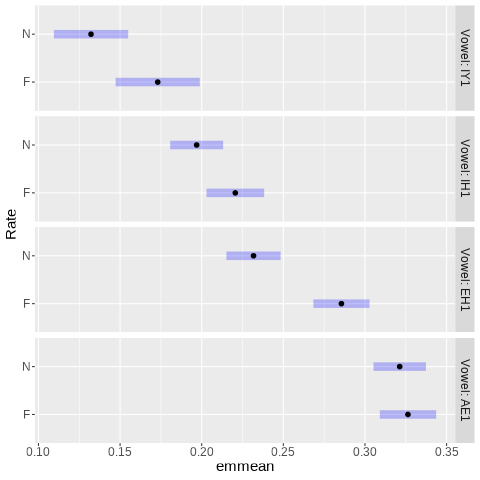

In [48]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.CM, by = "Vowel", intervals = TRUE, type = "response")

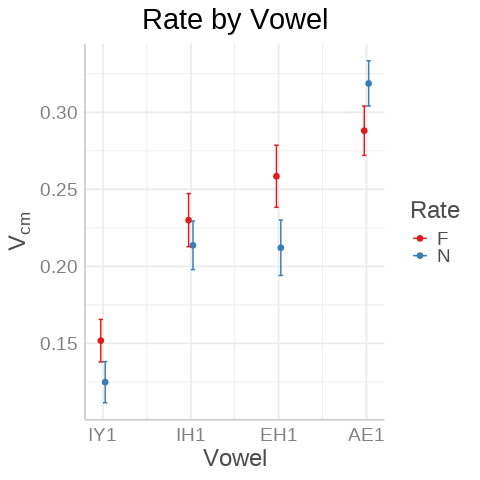

In [49]:
%%R
plot_model(m.CM, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab(TeX('V_{cm}'))

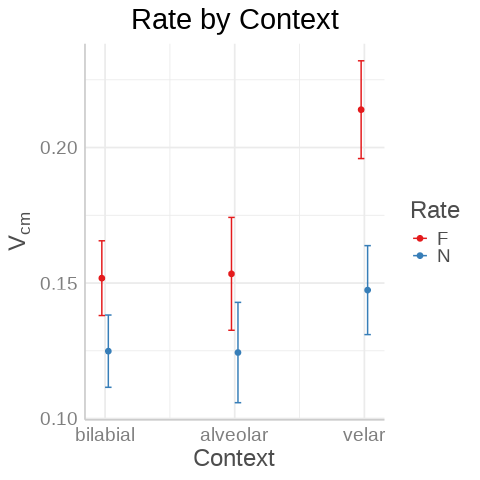

In [50]:
%%R
plot_model(m.CM, type = "pred", terms = c("Context", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab(TeX('V_{cm}'))

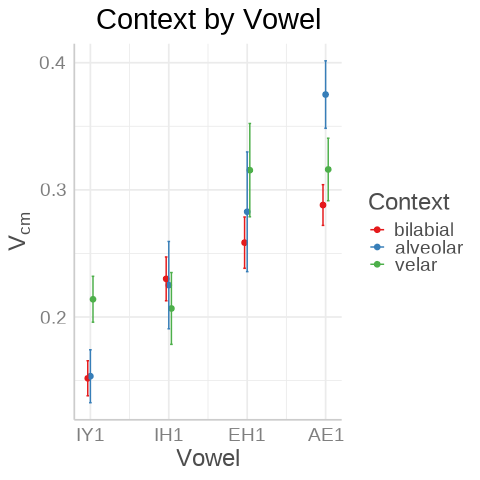

In [51]:
%%R
plot_model(m.CM, type='pred', terms=c("Vowel","Context"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Context by Vowel') +
    ylab(TeX('V_{cm}'))

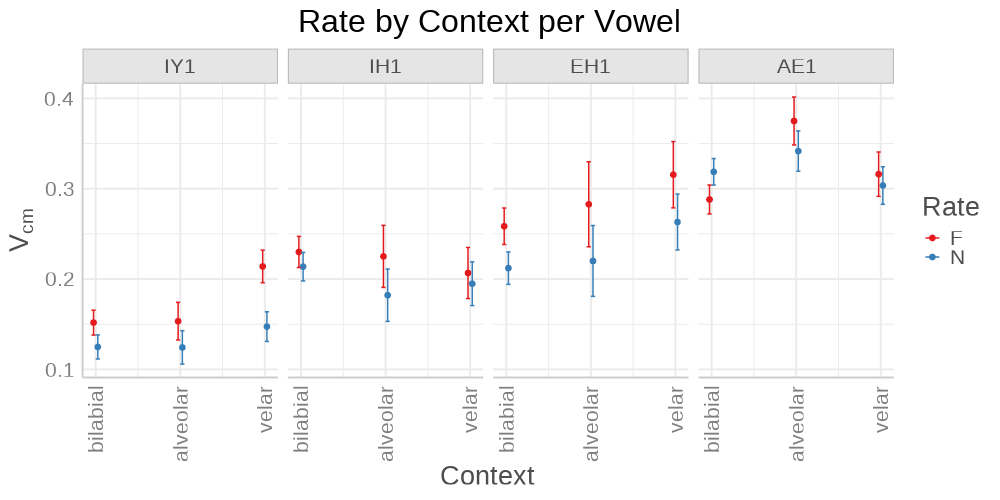

In [52]:
%%R -w 1000 -h 500
plot_model(m.CM, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab(TeX('V_{cm}'))
    #+ ylim(-0.6, 0.6)

## (3) LME model when DV: IS

In [53]:
%%R
m.IS = lmer(ucm_minus_cm_over_var ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.IS)

Linear mixed model fit by REML ['lmerMod']
Formula: ucm_minus_cm_over_var ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 9747.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.59794 -0.74776  0.07731  0.78177  2.83972 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.008295 0.09108 
 Residual             0.184943 0.43005 
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             -0.069682   0.034113  -2.043
RateN                   -0.009218   0.014549  -0.634
Context.L                0.031593   0.022558   1.401
Context.Q                0.030445   0.015839   1.922
Vowel.L                 -0.097755   0.026321  -3.714
Vowel.Q                 -0.031691   0.022515  -1.408
Vowel.C                 -0.041401   0.017907  -2.312
RateN:Context.L         -0.011352   0.029235  -0.388
RateN:Context.Q         -0.002778   0.020377  -0.136

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [54]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.IS, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: ucm_minus_cm_over_var
                     Chisq Df Pr(>Chisq)    
(Intercept)         4.1725  1    0.04108 *  
Rate                0.4014  1    0.52636    
Context             3.8625  2    0.14496    
Vowel              34.1562  3  1.836e-07 ***
Rate:Context        0.1598  2    0.92323    
Rate:Vowel          8.1481  3    0.04305 *  
Context:Vowel       7.2009  6    0.30267    
Rate:Context:Vowel 11.2724  6    0.08031 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [55]:
%%R
em.IS = emmeans(m.IS, ~ Rate|Vowel, adjust = "tukey")
pairs(em.IS)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0375 0.0454 Inf -0.826  0.4086 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0326 0.0215 Inf  1.512  0.1305 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0157 0.0213 Inf -0.738  0.4607 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0575 0.0203 Inf  2.832  0.0046 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [56]:
%%R
em.IS_1 = emmeans(m.IS, ~ Rate|Context, adjust = "tukey")
pairs(em.IS_1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00233 0.0168 Inf 0.138   0.8900 

Context = alveolar:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00695 0.0140 Inf 0.497   0.6192 

Context = velar:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.01838 0.0378 Inf 0.487   0.6265 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [57]:
%%R
em.IS_2 = emmeans(m.IS, ~ Context|Vowel, adjust = "tukey")
pairs(em.IS_2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast            estimate     SE  df z.ratio p.value
 bilabial - alveolar   0.0088 0.0233 Inf  0.378  0.9243 
 bilabial - velar     -0.0618 0.0667 Inf -0.927  0.6231 
 alveolar - velar     -0.0706 0.0653 Inf -1.081  0.5260 

Vowel = IH1:
 contrast            estimate     SE  df z.ratio p.value
 bilabial - alveolar  -0.0398 0.0240 Inf -1.660  0.2209 
 bilabial - velar     -0.0550 0.0291 Inf -1.890  0.1415 
 alveolar - velar     -0.0153 0.0258 Inf -0.592  0.8244 

Vowel = EH1:
 contrast            estimate     SE  df z.ratio p.value
 bilabial - alveolar   0.0451 0.0189 Inf  2.384  0.0452 
 bilabial - velar     -0.0139 0.0295 Inf -0.471  0.8851 
 alveolar - velar     -0.0590 0.0285 Inf -2.066  0.0970 

Vowel = AE1:
 contrast            estimate     SE  df z.ratio p.value
 bilabial - alveolar   0.0549 0.0209 Inf  2.625  0.0236 
 bilabial - velar     -0.0159 0.0260 Inf -0.611  0.8141 
 alveolar - velar     -0.0708 0.0272 Inf -2.605  0.0249 

Results are averaged over the le

In [58]:
%%R
em.IS.poa = emmeans(m.IS, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.IS.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast  estimate     SE  df z.ratio p.value
 F - N    -0.061545 0.0379 Inf -1.623  0.1045 

Context = alveolar, Vowel = IY1:
 contrast  estimate     SE  df z.ratio p.value
 F - N     0.009920 0.0270 Inf  0.367  0.7135 

Context = velar, Vowel = IY1:
 contrast  estimate     SE  df z.ratio p.value
 F - N    -0.060806 0.1278 Inf -0.476  0.6343 

Context = bilabial, Vowel = IH1:
 contrast  estimate     SE  df z.ratio p.value
 F - N     0.061932 0.0390 Inf  1.590  0.1119 

Context = alveolar, Vowel = IH1:
 contrast  estimate     SE  df z.ratio p.value
 F - N     0.000193 0.0279 Inf  0.007  0.9945 

Context = velar, Vowel = IH1:
 contrast  estimate     SE  df z.ratio p.value
 F - N     0.035583 0.0433 Inf  0.822  0.4111 

Context = bilabial, Vowel = EH1:
 contrast  estimate     SE  df z.ratio p.value
 F - N    -0.079480 0.0287 Inf -2.771  0.0056 

Context = alveolar, Vowel = EH1:
 contrast  estimate     SE  df z.ratio p.value
 F - N    -0.008322 0.0247 Inf

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



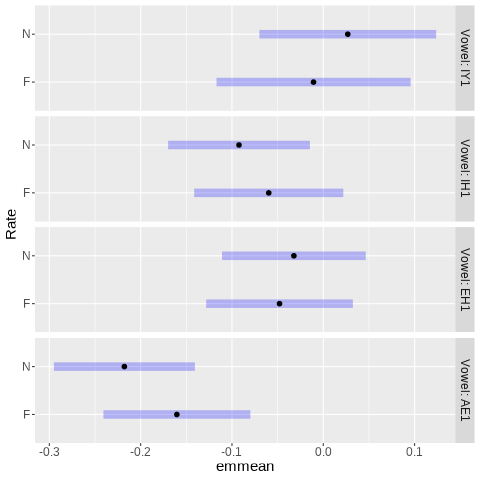

In [59]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.IS, by = "Vowel", intervals = TRUE, type = "response")

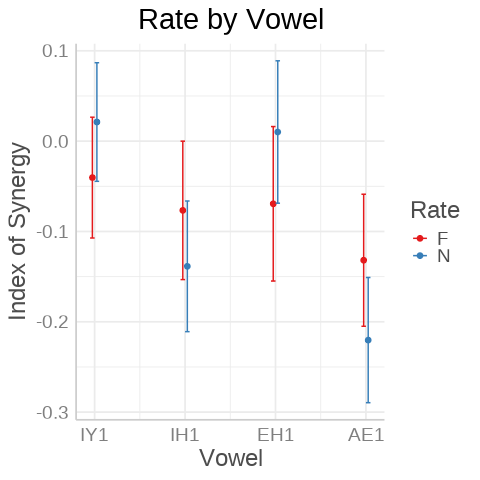

In [60]:
%%R
plot_model(m.IS, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab('Index of Synergy')

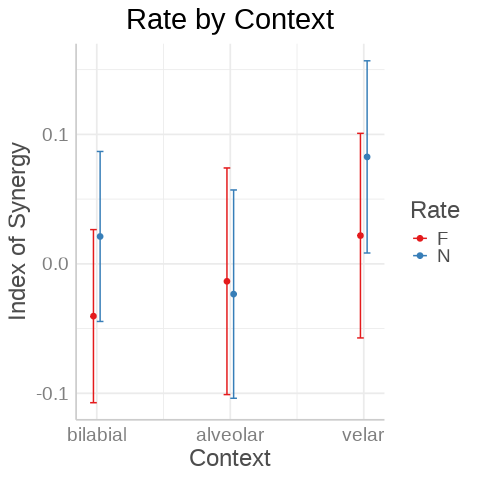

In [61]:
%%R
plot_model(m.IS, type = "pred", terms = c("Context", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab('Index of Synergy')

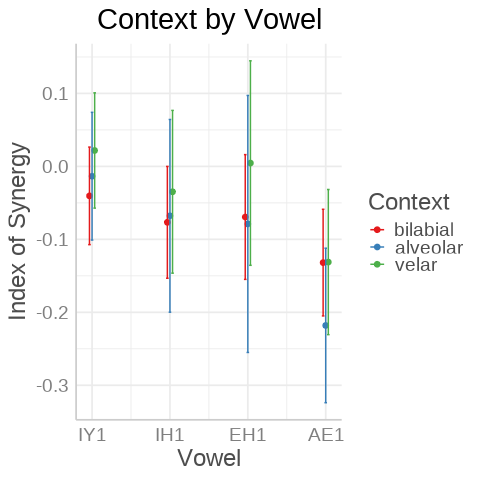

In [62]:
%%R
plot_model(m.IS, type='pred', terms=c("Vowel","Context"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Context by Vowel') +
    ylab('Index of Synergy')

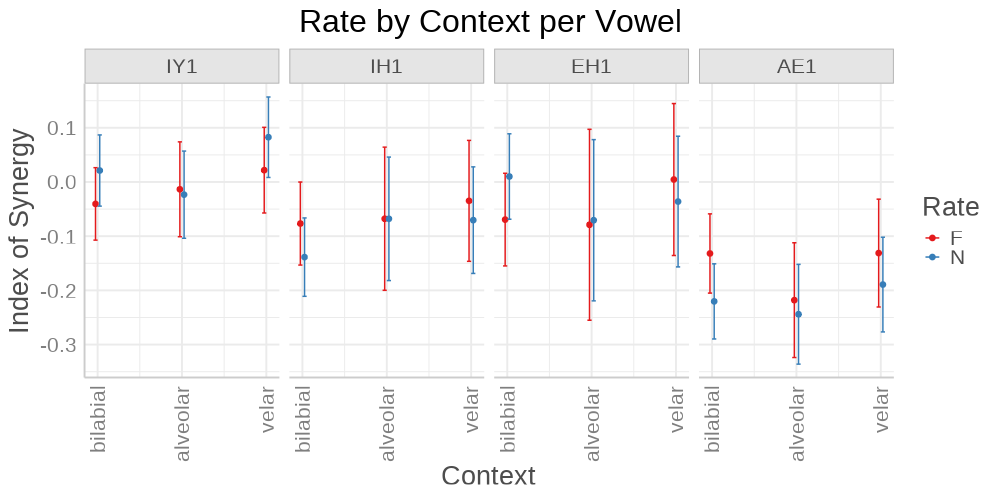

In [63]:
%%R -w 1000 -h 500
plot_model(m.IS, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab('Index of Synergy')
    #+ ylim(-0.7, 0.6)

## (4) LME model when DV: ucm_ratio_quotient

In [65]:
%%R
m.QT = lmer(ucm_ratio_quotient ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.QT)

Linear mixed model fit by REML ['lmerMod']
Formula: ucm_ratio_quotient ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 15793.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0292 -0.8989 -0.0125  0.9008  2.2588 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.01828  0.1352  
 Residual             0.38248  0.6184  
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                          Estimate Std. Error t value
(Intercept)             -0.0770600  0.0504759  -1.527
RateN                   -0.0057084  0.0209227  -0.273
Context.L                0.0398678  0.0324407   1.229
Context.Q                0.0391411  0.0227771   1.718
Vowel.L                 -0.1526323  0.0378512  -4.032
Vowel.Q                 -0.0368974  0.0323789  -1.140
Vowel.C                 -0.0655060  0.0257523  -2.544
RateN:Context.L         -0.0012864  0.0420419  -0.031
RateN:Context.Q          0.0038837  0.0293045   0.133
R

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [66]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.QT, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: ucm_ratio_quotient
                     Chisq Df Pr(>Chisq)    
(Intercept)         2.3307  1    0.12684    
Rate                0.0744  1    0.78498    
Context             3.0675  2    0.21573    
Vowel              36.2319  3  6.689e-08 ***
Rate:Context        0.0332  2    0.98354    
Rate:Vowel          7.6075  3    0.05486 .  
Context:Vowel       7.9395  6    0.24257    
Rate:Context:Vowel 12.2528  6    0.05656 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [67]:
%%R
em.QT = emmeans(m.QT, ~ Rate|Vowel, adjust = "tukey")
pairs(em.QT)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0624 0.0652 Inf -0.956  0.3389 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0396 0.0310 Inf  1.278  0.2012 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0273 0.0306 Inf -0.890  0.3735 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0729 0.0292 Inf  2.496  0.0125 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [68]:
%%R
em.QT.poa = emmeans(m.QT, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.QT.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.09183 0.0545 Inf -1.684  0.0922 

Context = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.01174 0.0389 Inf  0.302  0.7625 

Context = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.10704 0.1838 Inf -0.582  0.5604 

Context = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.07997 0.0560 Inf  1.427  0.1535 

Context = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00335 0.0402 Inf -0.084  0.9334 

Context = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.04214 0.0623 Inf  0.677  0.4985 

Context = bilabial, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.11177 0.0412 Inf -2.710  0.0067 

Context = alveolar, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00598 0.0355 Inf -0.169  0.8661 

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



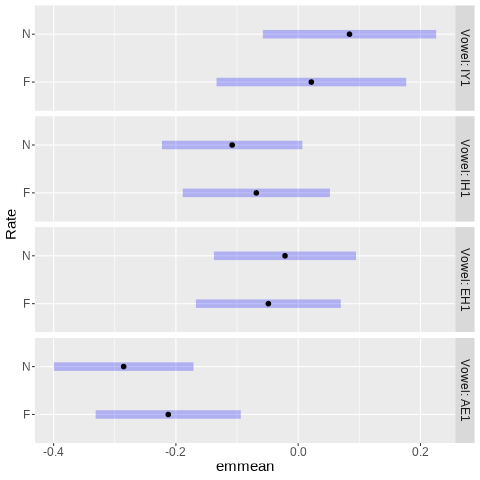

In [69]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.QT, by = "Vowel", intervals = TRUE, type = "response")

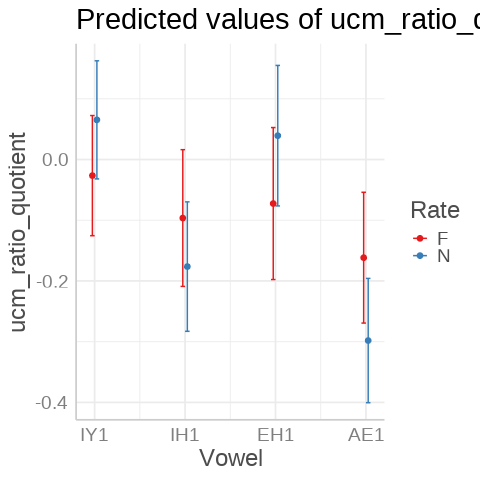

In [70]:
%%R
plot_model(m.QT, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

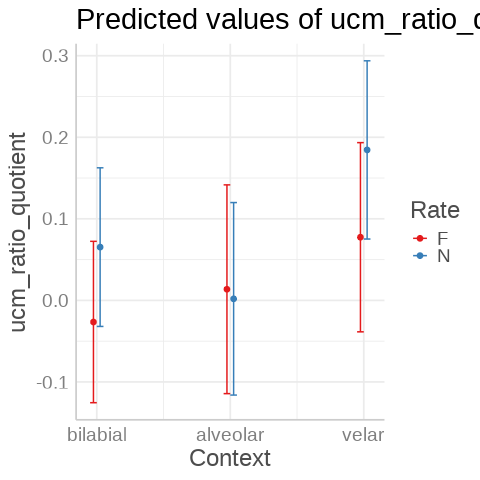

In [71]:
%%R
plot_model(m.QT, type='pred', terms=c("Context","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

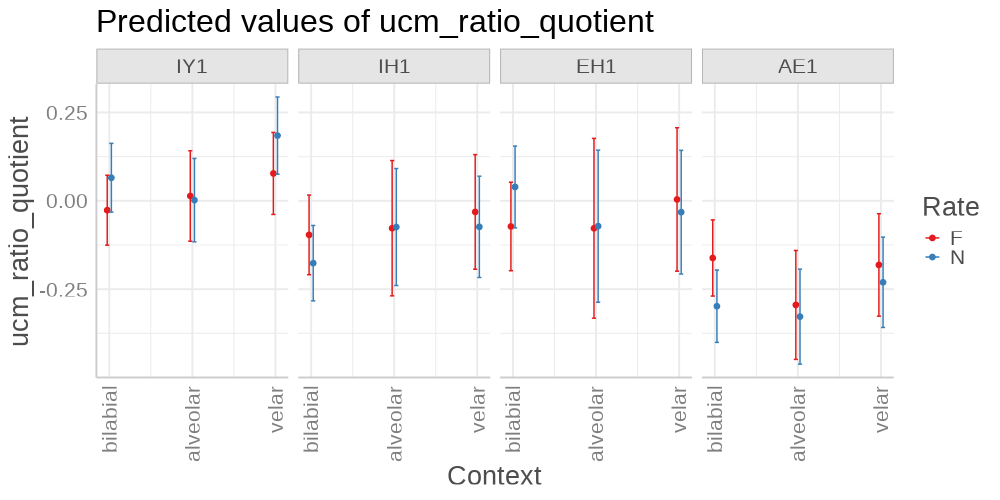

In [72]:
%%R -w 1000 -h 500
plot_model(m.QT, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
    #+ ylim(-0.7, 0.6)